In [17]:
import yfinance as yf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd
import requests
from bs4 import BeautifulSoup
import yfinance as yf
import time

In [38]:
ASSET_CLASS_ETFS = {
    'Equities': ['SPY', 'QQQ', 'IWM', 'EFA'],
    'Rates': ['TLT', 'IEF', 'SHY'],
    'Commodities': ['GLD', 'USO', 'DBA'],
    'FX': ['FXE', 'FXY', 'FXB']
}

# SECTOR ETFs - For sector rotation and relative value analysis

SECTOR_ETFS = {
    'Technology': 'XLK',
    'Financials': 'XLF',
    'Healthcare': 'XLV',
    'Energy': 'XLE',
    'Consumer Discretionary': 'XLY',
    'Consumer Staples': 'XLP',
    'Industrials': 'XLI',
    'Materials': 'XLB',
    'Real Estate': 'XLRE',
    'Utilities': 'XLU',
    'Communication Services': 'XLC'
}

# SECTOR REPRESENTATIVE STOCKS - Individual stocks for sector analysis

SECTOR_LEADERS = {
    'Technology': ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'META'],
    'Financials': ['JPM', 'BAC', 'WFC', 'GS', 'MS'],
    'Healthcare': ['UNH', 'JNJ', 'LLY', 'ABBV', 'MRK'],
    'Energy': ['XOM', 'CVX', 'COP', 'SLB', 'EOG'],
    'Consumer Discretionary': ['AMZN', 'TSLA', 'HD', 'MCD', 'NKE'],
    'Consumer Staples': ['WMT', 'PG', 'KO', 'PEP', 'COST'],
    'Industrials': ['BA', 'CAT', 'HON', 'UNP', 'GE'],
    'Materials': ['LIN', 'APD', 'SHW', 'NEM', 'FCX'],
    'Real Estate': ['PLD', 'AMT', 'SPG', 'EQIX', 'PSA'],
    'Utilities': ['NEE', 'DUK', 'SO', 'D', 'AEP'],
    'Communication Services': ['GOOGL', 'META', 'DIS', 'NFLX', 'CMCSA']
}

# RECOMMENDED UNIVERSES FOR DIFFERENT ANALYSES

MINIMAL_CROSS_ASSET = (
    ASSET_CLASS_ETFS['Equities'] + 
    ASSET_CLASS_ETFS['Rates'] + 
    ASSET_CLASS_ETFS['Commodities'] + 
    ASSET_CLASS_ETFS['FX']
)

# Universe 2: Cross-asset + sectors (24 assets, 276 pairs)
CROSS_ASSET_WITH_SECTORS = MINIMAL_CROSS_ASSET + list(SECTOR_ETFS.values())

In [39]:
all_tickers = CROSS_ASSET_WITH_SECTORS
data = yf.download(all_tickers, start="2020-01-01", auto_adjust=True)

if isinstance(data.columns, pd.MultiIndex):
    prices = data['Close']
else:
    prices = data[['Close']]
    prices.columns = all_tickers
print(prices.head())

# Calculate returns
returns = prices.pct_change().dropna()

# Make sure we only have tickers
assert all(col in all_tickers for col in returns.columns), "ERROR: Non-ticker columns found!"
assert 'Close' not in returns.columns, "ERROR: 'Close' still in columns!"
assert 'High' not in returns.columns, "ERROR: 'High' still in columns!"
assert 'Volume' not in returns.columns, "ERROR: 'Volume' still in columns!"

[*********************100%***********************]  24 of 24 completed


Ticker            DBA        EFA         FXB         FXE        FXY  \
Date                                                                  
2020-01-02  14.560221  58.637089  117.031319  100.962296  87.510002   
2020-01-03  14.392557  57.909763  116.415848  100.905083  87.919998   
2020-01-06  14.427855  58.135475  117.279343  101.162598  87.650002   
2020-01-07  14.463151  57.976643  116.856789  100.723839  87.510002   
2020-01-08  14.392557  58.143845  116.663849  100.428169  87.099998   

Ticker             GLD        IEF         IWM         QQQ        SHY  ...  \
Date                                                                  ...   
2020-01-02  143.949997  96.231712  153.706055  208.580185  74.180847  ...   
2020-01-03  145.860001  96.874847  153.103348  206.669632  74.242126  ...   
2020-01-06  147.389999  96.770561  153.307343  208.001205  74.215874  ...   
2020-01-07  147.970001  96.631500  152.797394  207.972321  74.215874  ...   
2020-01-08  146.860001  96.405533  153.2

In [40]:
# Rolling correlation with lookback windows
short_window = 30
long_window = 252 # 252 trading days in a year
rolling_corr = returns.rolling(window=short_window).corr()
historical_corr = returns.rolling(window=long_window).corr()

In [41]:
# current vs historical correlation heatmap
def plot_correlation_comparison(returns, short_window, long_window):
    current_corr = returns.tail(short_window).corr()
    historical_corr = returns.corr()
    diff_corr = current_corr - historical_corr
    fig, axes = plt.subplots(1,3, figsize=(20,6))

    # Plot 1: Current correlations
    sns.heatmap(current_corr, annot=True, fmt=".2f", cmap="RdYlGn", 
               center=0, vmin=-1, vmax=1, ax=axes[0], cbar_kws={"label" : "Correlation"})
    axes[0].set_title(f'Current Correlation (Last {short_window} Days)', fontsize=14, fontweight="bold")
    
    # Plot 2: Historical correlations
    sns.heatmap(historical_corr, annot=True, fmt='.2f', cmap='RdYlGn', 
                center=0, vmin=-1, vmax=1, ax=axes[1], cbar_kws={'label': 'Correlation'})
    axes[1].set_title('Historical Correlation (Full Period)', fontsize=14, fontweight='bold')
    
    # Plot 3: Difference (dislocations)
    sns.heatmap(diff_corr, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, vmin=-0.5, vmax=0.5, ax=axes[2], cbar_kws={'label': 'Difference'})
    axes[2].set_title('Dislocation (Current - Historical)', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return current_corr, historical_corr, diff_corr

# 2. STATISTICAL ALERTS - FLAG REGIME BREAKS
def detect_dislocations(returns, short_window=30, long_window=252, threshold=2):
    """Identify correlation pairs that have broken from historical norms"""
    
    # Calculate rolling correlation for each pair
    all_pairs = []
    
    for i, ticker1 in enumerate(returns.columns):
        for ticker2 in returns.columns[i+1:]:
            # Rolling correlation
            rolling_corr = returns[ticker1].rolling(long_window).corr(returns[ticker2])
            
            # Historical mean and std
            hist_mean = rolling_corr.mean()
            hist_std = rolling_corr.std()
            
            # Current correlation
            current_corr = returns[ticker1].tail(short_window).corr(returns[ticker2])
            
            # Z-score
            z_score = (current_corr - hist_mean) / hist_std if hist_std != 0 else 0
            
            # Store results
            all_pairs.append({
                'Pair': f'{ticker1} vs {ticker2}',
                'Current': current_corr,
                'Historical Mean': hist_mean,
                'Historical Std': hist_std,
                'Z-Score': z_score,
                'Alert': 'YES' if abs(z_score) > threshold else 'NO',
                'Direction': 'STRONGER' if z_score > 0 else 'WEAKER'
            })
    
    df_alerts = pd.DataFrame(all_pairs)
    df_alerts = df_alerts.sort_values('Z-Score', key=abs, ascending=False)
    
    return df_alerts

In [42]:
# 3. TIME SERIES OF KEY CORRELATIONS
def plot_key_correlations(returns, pairs, window=60):
    """Plot how specific correlations evolve over time"""
    
    fig, axes = plt.subplots(len(pairs), 1, figsize=(14, 4*len(pairs)))
    if len(pairs) == 1:
        axes = [axes]
    
    for idx, (ticker1, ticker2) in enumerate(pairs):
        # Rolling correlation
        rolling_corr = returns[ticker1].rolling(window).corr(returns[ticker2])
        
        # Historical mean and std bands
        hist_mean = rolling_corr.mean()
        hist_std = rolling_corr.std()
        
        # Plot
        ax = axes[idx]
        ax.plot(rolling_corr.index, rolling_corr, label='Rolling Correlation', linewidth=2)
        ax.axhline(hist_mean, color='black', linestyle='--', label='Historical Mean', linewidth=1.5)
        ax.axhline(hist_mean + 2*hist_std, color='red', linestyle=':', label='±2σ', linewidth=1)
        ax.axhline(hist_mean - 2*hist_std, color='red', linestyle=':', linewidth=1)
        ax.fill_between(rolling_corr.index, hist_mean - hist_std, hist_mean + hist_std, 
                         alpha=0.2, color='gray', label='±1σ Band')
        
        ax.set_title(f'{ticker1} vs {ticker2} - Rolling {window}d Correlation', fontsize=12, fontweight='bold')
        ax.set_ylabel('Correlation')
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### Finding top correlations

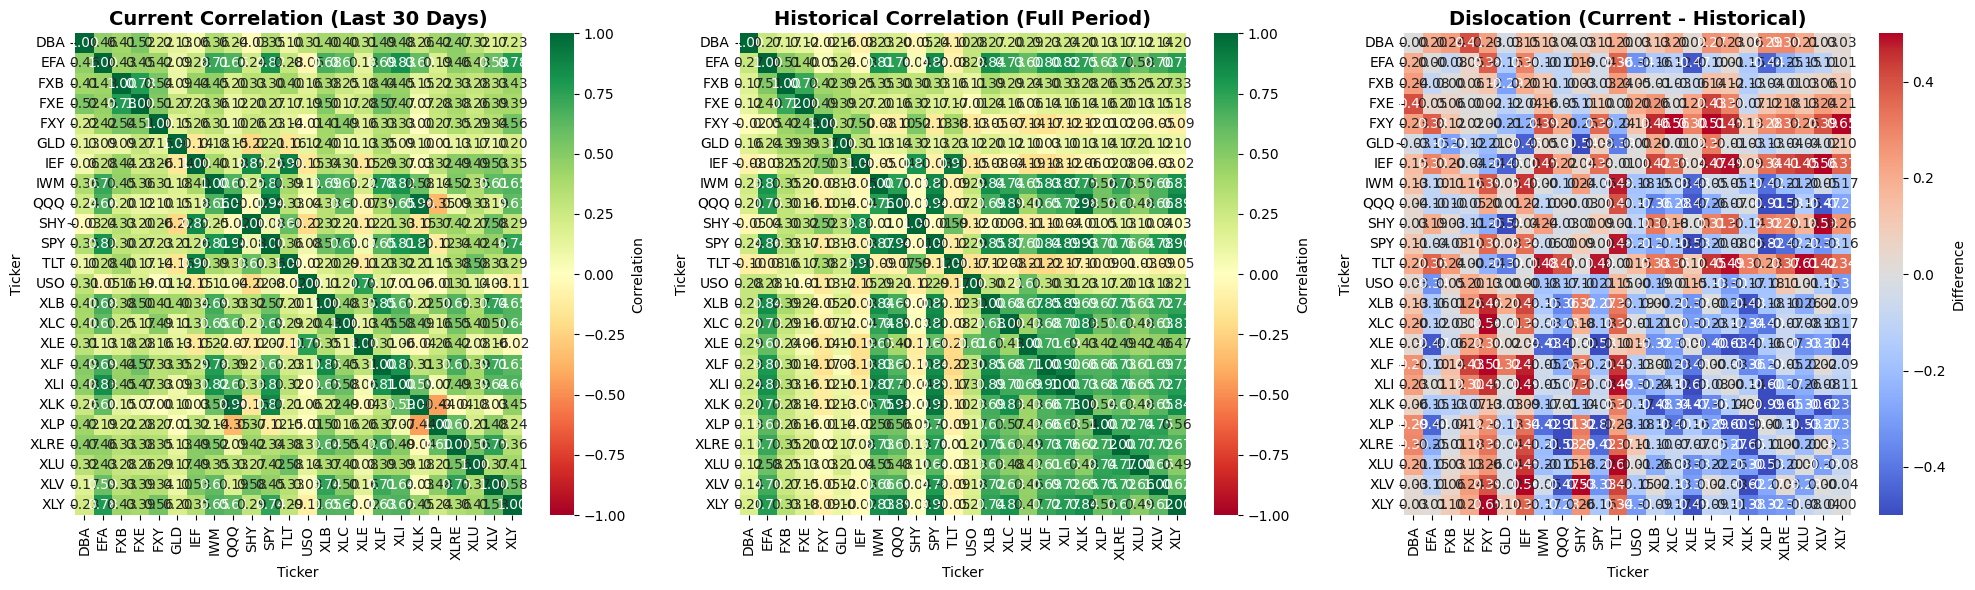


Top 20 Correlation Changes (by |Z-Score|):
       Pair   Current  Historical Mean  Historical Std   Z-Score Alert Direction
 QQQ vs XLY  0.610552         0.865070        0.047268 -5.384542   YES    WEAKER
 XLK vs XLY  0.453452         0.796934        0.067288 -5.104637   YES    WEAKER
 DBA vs FXE  0.524889         0.135795        0.079003  4.925025   YES  STRONGER
 XLE vs XLI  0.061787         0.562363        0.106956 -4.680200   YES    WEAKER
 XLP vs XLU  0.212200         0.631817        0.092415 -4.540577   YES    WEAKER
 QQQ vs XLC  0.607343         0.851257        0.055105 -4.426389   YES    WEAKER
 SPY vs XLY  0.736588         0.877353        0.032657 -4.310394   YES    WEAKER
 QQQ vs XLP -0.352553         0.411332        0.179440 -4.257051   YES    WEAKER
 XLB vs XLI  0.650292         0.853578        0.048049 -4.230818   YES    WEAKER
 SPY vs XLP -0.120299         0.573912        0.166357 -4.173022   YES    WEAKER
 SHY vs XLV  0.575238         0.112417        0.116752  3.964143 

In [44]:
# Generate visualizations
current_corr, historical_corr, diff_corr = plot_correlation_comparison(returns, short_window = 30, long_window = 252)

# Detect dislocations
df_alerts = detect_dislocations(returns)

# Show top dislocations
print("\nTop 20 Correlation Changes (by |Z-Score|):")
print(df_alerts.head(20).to_string(index=False))

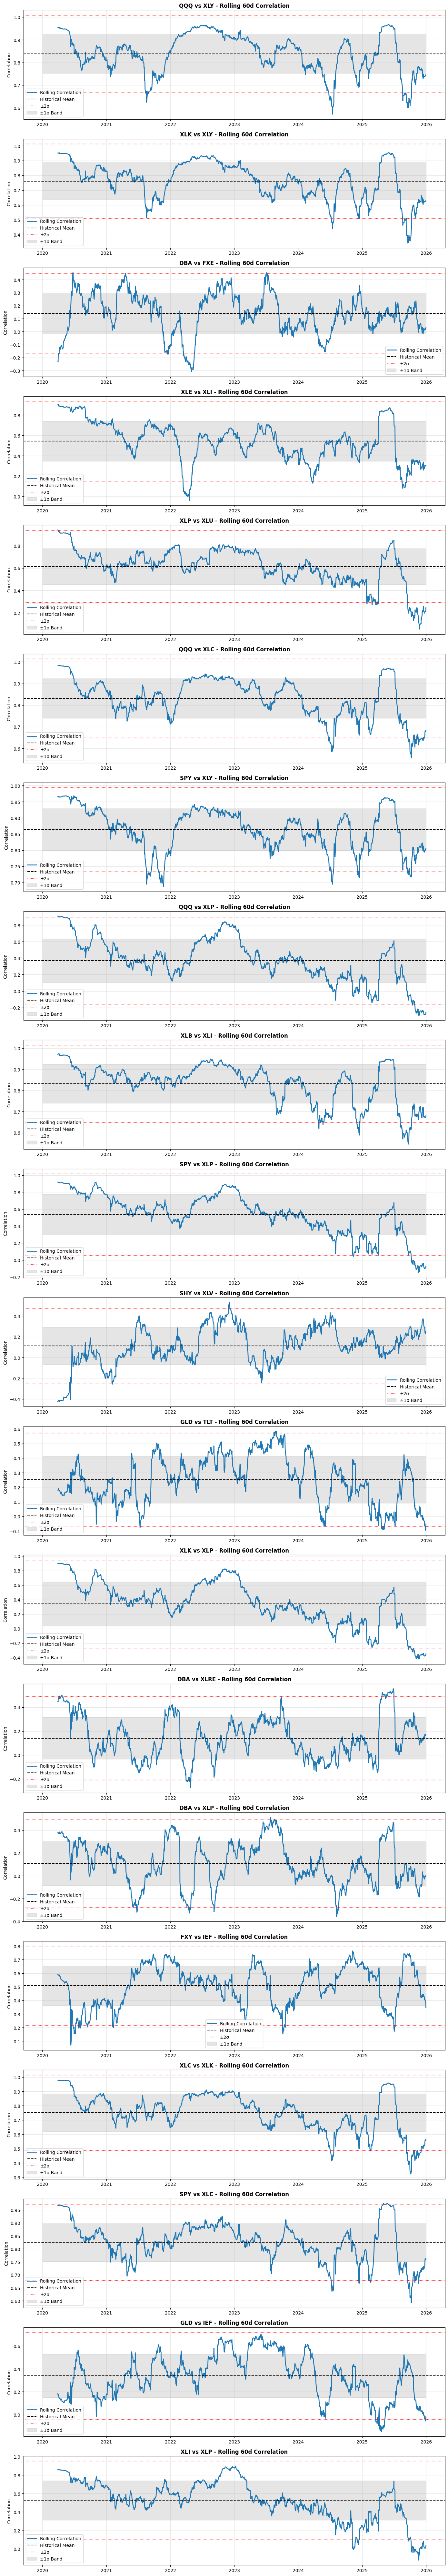

In [45]:
pairs = [
    ("QQQ", "XLY"),
    ("XLK", "XLY"),
    ("DBA", "FXE"),
    ("XLE", "XLI"),
    ("XLP", "XLU"),
    ("QQQ", "XLC"),
    ("SPY", "XLY"),
    ("QQQ", "XLP"),
    ("XLB", "XLI"),
    ("SPY", "XLP"),
    ("SHY", "XLV"),
    ("GLD", "TLT"),
    ("XLK", "XLP"),
    ("DBA", "XLRE"),
    ("DBA", "XLP"),
    ("FXY", "IEF"),
    ("XLC", "XLK"),
    ("SPY", "XLC"),
    ("GLD", "IEF"),
    ("XLI", "XLP"),
]

plot_key_correlations(returns, pairs, window=60)

When correlations break from expected patterns, such as the classic equity-bond hedge relationship deteriorating, it creates actionable trading opportunities through mean reversion or signals regime changes in market structure.